In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

First experiment, comparing all splitting heuristics.
First I generated 10 random seeds which will be used for each experiment.

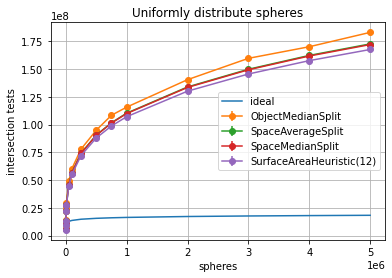

In [28]:
with open("experiments/results/compare_splitting_heuristics.json") as f:
    data = json.load(f)
    
    nb_spheres = np.array(data['nb_spheres'])
    
    fig, ax = plt.subplots()
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set(xlabel='spheres', ylabel='intersection tests',
       title='Uniformly distribute spheres')
    
    ideal = 640 * 640 * 2 * np.log2(nb_spheres)
    ax.plot(nb_spheres, ideal, label='ideal')
        
    for (splitting_heuristic, intersection_tests) in sorted(data['results'].items()):        
        results = [np.array(k) for k in intersection_tests]
        averages = np.array([np.average(res) for res in results])
        stds = np.array([np.std(res) for res in results])

        
        ax.errorbar(nb_spheres, averages, yerr=stds, fmt='-o', label=splitting_heuristic)
        
    ax.grid(True)
    ax.legend()
    plt.savefig('experiments/plots/compare_splitting_heuristics.png')

From here on a new json format was used

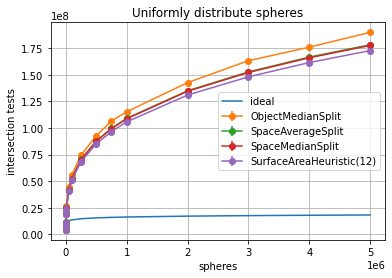

In [30]:
with open("experiments/results/compare_splitting_heuristics2.json") as f:
    data = json.load(f)
    
    nb_spheres = np.array(data['nb_spheres'])
    
    fig, ax = plt.subplots()
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set(xlabel='spheres', ylabel='intersection tests',
       title='Uniformly distribute spheres')
    
    ideal = 640 * 640 * 2 * np.log2(nb_spheres)
    ax.plot(nb_spheres, ideal, label='ideal')
        
    for (splitting_heuristic, intersection_tests) in sorted(data['results'].items()):        
        results = [np.array(k) for k in intersection_tests]
        averages = np.array([np.average(res) for res in results])
        stds = np.array([np.std(res) for res in results])

        
        ax.errorbar(nb_spheres, averages, yerr=stds, fmt='-o', label=splitting_heuristic)
        
    ax.grid(True)
    ax.legend()
    plt.savefig('experiments/plots/compare_splitting_heuristics2.png')
